In [1]:
using DataFrames
using Gadfly
using Chemfiles
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

In [4]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)));

# Leo indices
idx_vol0 = convert(Array{Int64, 1},
    readdlm(joinpath(home, rtdos, string(pdb, "_idx_vol", 0)))[:, 1])
idx_vol1 = convert(Array{Int64, 1},
    readdlm(joinpath(home, rtdos, string(pdb, "_idx_vol", 1)))[:, 1])
idx_vol2 = convert(Array{Int64, 1},
    readdlm(joinpath(home, rtdos, string(pdb, "_idx_vol", 2)))[:, 1]);

# Leo vectores diferencia.
diff_4xcp = readdlm(joinpath(rtdos, "diff_4xcp"))
nframes = size(diff_4xcp)[2]
norm_diff_4xcp = mapslices(x -> x ./ norm(x), diff_4xcp, 1);

prj_1_4xcp = Array{Float64, 1}(nframes)
prj_2_4xcp = Array{Float64, 1}(nframes)
prj_3_4xcp = Array{Float64, 1}(nframes)
prj_4_4xcp = Array{Float64, 1}(nframes)
prj_5_4xcp = Array{Float64, 1}(nframes)
prj_6_4xcp = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp[:, 3])
    prj_4_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp[:, 4])
    prj_5_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp[:, 5])
    prj_6_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp[:, 6])
end

## x = PCA

In [7]:
steps = convert(Array{Int64}, [ 5E3 ; 10E3 ; 15E3 ; 20E3 ; 25E3 ; 30E3 ; 35E3 ; 40E3 ])

prj_1_4xcp_05 = [ prj_1_4xcp[i] for i = 1:1:steps[1] ]
prj_2_4xcp_05 = [ prj_2_4xcp[i] for i = 1:1:steps[1] ]
prj_3_4xcp_05 = [ prj_3_4xcp[i] for i = 1:1:steps[1] ]
prj_4_4xcp_05 = [ prj_4_4xcp[i] for i = 1:1:steps[1] ]
prj_5_4xcp_05 = [ prj_5_4xcp[i] for i = 1:1:steps[1] ]
prj_6_4xcp_05 = [ prj_6_4xcp[i] for i = 1:1:steps[1] ]

prj_1_4xcp_10 = [ prj_1_4xcp[i] for i = steps[1]:steps[2] ]
prj_2_4xcp_10 = [ prj_2_4xcp[i] for i = steps[1]:steps[2] ]
prj_3_4xcp_10 = [ prj_3_4xcp[i] for i = steps[1]:steps[2] ]
prj_4_4xcp_10 = [ prj_4_4xcp[i] for i = steps[1]:steps[2] ]
prj_5_4xcp_10 = [ prj_5_4xcp[i] for i = steps[1]:steps[2] ]
prj_6_4xcp_10 = [ prj_6_4xcp[i] for i = steps[1]:steps[2] ]

prj_1_4xcp_15 = [ prj_1_4xcp[i] for i = steps[2]:steps[3] ]
prj_2_4xcp_15 = [ prj_2_4xcp[i] for i = steps[2]:steps[3] ]
prj_3_4xcp_15 = [ prj_3_4xcp[i] for i = steps[2]:steps[3] ]
prj_4_4xcp_15 = [ prj_4_4xcp[i] for i = steps[2]:steps[3] ]
prj_5_4xcp_15 = [ prj_5_4xcp[i] for i = steps[2]:steps[3] ]
prj_6_4xcp_15 = [ prj_6_4xcp[i] for i = steps[2]:steps[3] ]

prj_1_4xcp_20 = [ prj_1_4xcp[i] for i = steps[3]:steps[4] ]
prj_2_4xcp_20 = [ prj_2_4xcp[i] for i = steps[3]:steps[4] ]
prj_3_4xcp_20 = [ prj_3_4xcp[i] for i = steps[3]:steps[4] ]
prj_4_4xcp_20 = [ prj_4_4xcp[i] for i = steps[3]:steps[4] ]
prj_5_4xcp_20 = [ prj_5_4xcp[i] for i = steps[3]:steps[4] ]
prj_6_4xcp_20 = [ prj_6_4xcp[i] for i = steps[3]:steps[4] ]

prj_1_4xcp_25 = [ prj_1_4xcp[i] for i = steps[4]:steps[5] ]
prj_2_4xcp_25 = [ prj_2_4xcp[i] for i = steps[4]:steps[5] ]
prj_3_4xcp_25 = [ prj_3_4xcp[i] for i = steps[4]:steps[5] ]
prj_4_4xcp_25 = [ prj_4_4xcp[i] for i = steps[4]:steps[5] ]
prj_5_4xcp_25 = [ prj_5_4xcp[i] for i = steps[4]:steps[5] ]
prj_6_4xcp_25 = [ prj_6_4xcp[i] for i = steps[4]:steps[5] ]

prj_1_4xcp_30 = [ prj_1_4xcp[i] for i = steps[5]:steps[6] ]
prj_2_4xcp_30 = [ prj_2_4xcp[i] for i = steps[5]:steps[6] ]
prj_3_4xcp_30 = [ prj_3_4xcp[i] for i = steps[5]:steps[6] ]
prj_4_4xcp_30 = [ prj_4_4xcp[i] for i = steps[5]:steps[6] ]
prj_5_4xcp_30 = [ prj_5_4xcp[i] for i = steps[5]:steps[6] ]
prj_6_4xcp_30 = [ prj_6_4xcp[i] for i = steps[5]:steps[6] ]

prj_1_4xcp_35 = [ prj_1_4xcp[i] for i = steps[6]:steps[7] ]
prj_2_4xcp_35 = [ prj_2_4xcp[i] for i = steps[6]:steps[7] ]
prj_3_4xcp_35 = [ prj_3_4xcp[i] for i = steps[6]:steps[7] ]
prj_4_4xcp_35 = [ prj_4_4xcp[i] for i = steps[6]:steps[7] ]
prj_5_4xcp_35 = [ prj_5_4xcp[i] for i = steps[6]:steps[7] ]
prj_6_4xcp_35 = [ prj_6_4xcp[i] for i = steps[6]:steps[7] ]

prj_1_4xcp_40 = [ prj_1_4xcp[i] for i = steps[7]:steps[8] ]
prj_2_4xcp_40 = [ prj_2_4xcp[i] for i = steps[7]:steps[8] ]
prj_3_4xcp_40 = [ prj_3_4xcp[i] for i = steps[7]:steps[8] ]
prj_4_4xcp_40 = [ prj_4_4xcp[i] for i = steps[7]:steps[8] ]
prj_5_4xcp_40 = [ prj_5_4xcp[i] for i = steps[7]:steps[8] ]
prj_6_4xcp_40 = [ prj_6_4xcp[i] for i = steps[7]:steps[8] ];

In [8]:
prj_16_4xcp_05 = [ prj_1_4xcp_05 prj_2_4xcp_05 prj_3_4xcp_05 prj_4_4xcp_05 prj_5_4xcp_05 prj_6_4xcp_05 ]
df_prj_16_4xcp_05 = DataFrame([ reshape(transpose(prj_16_4xcp_05), length(prj_16_4xcp_05)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_05)) repeat(collect(1:length(prj_2_4xcp_05)), inner = 6) ])

prj_16_4xcp_10 = [ prj_1_4xcp_10 prj_2_4xcp_10 prj_3_4xcp_10 prj_4_4xcp_10 prj_5_4xcp_10 prj_6_4xcp_10 ]
df_prj_16_4xcp_10 = DataFrame([ reshape(transpose(prj_16_4xcp_10), length(prj_16_4xcp_10)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_10)) repeat(collect(1:length(prj_2_4xcp_10)), inner = 6) ])
df_prj_16_4xcp_10 = df_prj_16_4xcp_10[1:end-6, :]

prj_16_4xcp_15 = [ prj_1_4xcp_15 prj_2_4xcp_15 prj_3_4xcp_15 prj_4_4xcp_15 prj_5_4xcp_15 prj_6_4xcp_15 ]
df_prj_16_4xcp_15 = DataFrame([ reshape(transpose(prj_16_4xcp_15), length(prj_16_4xcp_15)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_15)) repeat(collect(1:length(prj_2_4xcp_15)), inner = 6) ])
df_prj_16_4xcp_15 = df_prj_16_4xcp_15[1:end-6, :]

prj_16_4xcp_20 = [ prj_1_4xcp_20 prj_2_4xcp_20 prj_3_4xcp_20 prj_4_4xcp_20 prj_5_4xcp_20 prj_6_4xcp_20 ]
df_prj_16_4xcp_20 = DataFrame([ reshape(transpose(prj_16_4xcp_20), length(prj_16_4xcp_20)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_20)) repeat(collect(1:length(prj_2_4xcp_20)), inner = 6) ])
df_prj_16_4xcp_20 = df_prj_16_4xcp_20[1:end-6, :]

prj_16_4xcp_25 = [ prj_1_4xcp_25 prj_2_4xcp_25 prj_3_4xcp_25 prj_4_4xcp_25 prj_5_4xcp_25 prj_6_4xcp_25 ]
df_prj_16_4xcp_25 = DataFrame([ reshape(transpose(prj_16_4xcp_25), length(prj_16_4xcp_25)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_25)) repeat(collect(1:length(prj_2_4xcp_25)), inner = 6) ])
df_prj_16_4xcp_25 = df_prj_16_4xcp_25[1:end-6, :]

prj_16_4xcp_30 = [ prj_1_4xcp_30 prj_2_4xcp_30 prj_3_4xcp_30 prj_4_4xcp_30 prj_5_4xcp_30 prj_6_4xcp_30 ]
df_prj_16_4xcp_30 = DataFrame([ reshape(transpose(prj_16_4xcp_30), length(prj_16_4xcp_30)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_30)) repeat(collect(1:length(prj_2_4xcp_30)), inner = 6) ])
df_prj_16_4xcp_30 = df_prj_16_4xcp_30[1:end-6, :]

prj_16_4xcp_35 = [ prj_1_4xcp_35 prj_2_4xcp_35 prj_3_4xcp_35 prj_4_4xcp_35 prj_5_4xcp_35 prj_6_4xcp_35 ]
df_prj_16_4xcp_35 = DataFrame([ reshape(transpose(prj_16_4xcp_35), length(prj_16_4xcp_35)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_35)) repeat(collect(1:length(prj_2_4xcp_35)), inner = 6) ])
df_prj_16_4xcp_35 = df_prj_16_4xcp_35[1:end-6, :]

prj_16_4xcp_40 = [ prj_1_4xcp_40 prj_2_4xcp_40 prj_3_4xcp_40 prj_4_4xcp_40 prj_5_4xcp_40 prj_6_4xcp_40 ]
df_prj_16_4xcp_40 = DataFrame([ reshape(transpose(prj_16_4xcp_40), length(prj_16_4xcp_40)) repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], outer = length(prj_2_4xcp_40)) repeat(collect(1:length(prj_2_4xcp_40)), inner = 6) ]);
df_prj_16_4xcp_40 = df_prj_16_4xcp_40[1:end-6, :]

set_default_plot_size(50cm, 30cm);

In [20]:
plot(df_prj_16_4xcp_05, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("0us - 0.5us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),

    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        key_title_font_size = 80pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_05 not defined[39m

In [21]:
plot(df_prj_16_4xcp_10, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("0.5us - 1.0us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    
    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_10 not defined[39m

In [22]:
plot(df_prj_16_4xcp_15, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("1.0us - 1.5us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    
    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_15 not defined[39m

In [23]:
plot(df_prj_16_4xcp_20, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("1.5us - 2.0us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    
    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_20 not defined[39m

In [24]:
plot(df_prj_16_4xcp_25, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("2.0us - 2.5us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    
    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_25 not defined[39m

In [25]:
plot(df_prj_16_4xcp_30, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("2.5us - 3.0us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),

    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_30 not defined[39m

In [26]:
plot(df_prj_16_4xcp_35, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("3.0us - 3.5us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),

    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_35 not defined[39m

In [27]:
plot(df_prj_16_4xcp_40, x = "x2", y = "x1", color = "x3",
    Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("3.5us - 4.0us"),
    Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),


    Theme(bar_spacing=2pt, grid_line_width = 0pt, line_width = .5pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

LoadError: [91mUndefVarError: df_prj_16_4xcp_40 not defined[39m

## x = tiempo

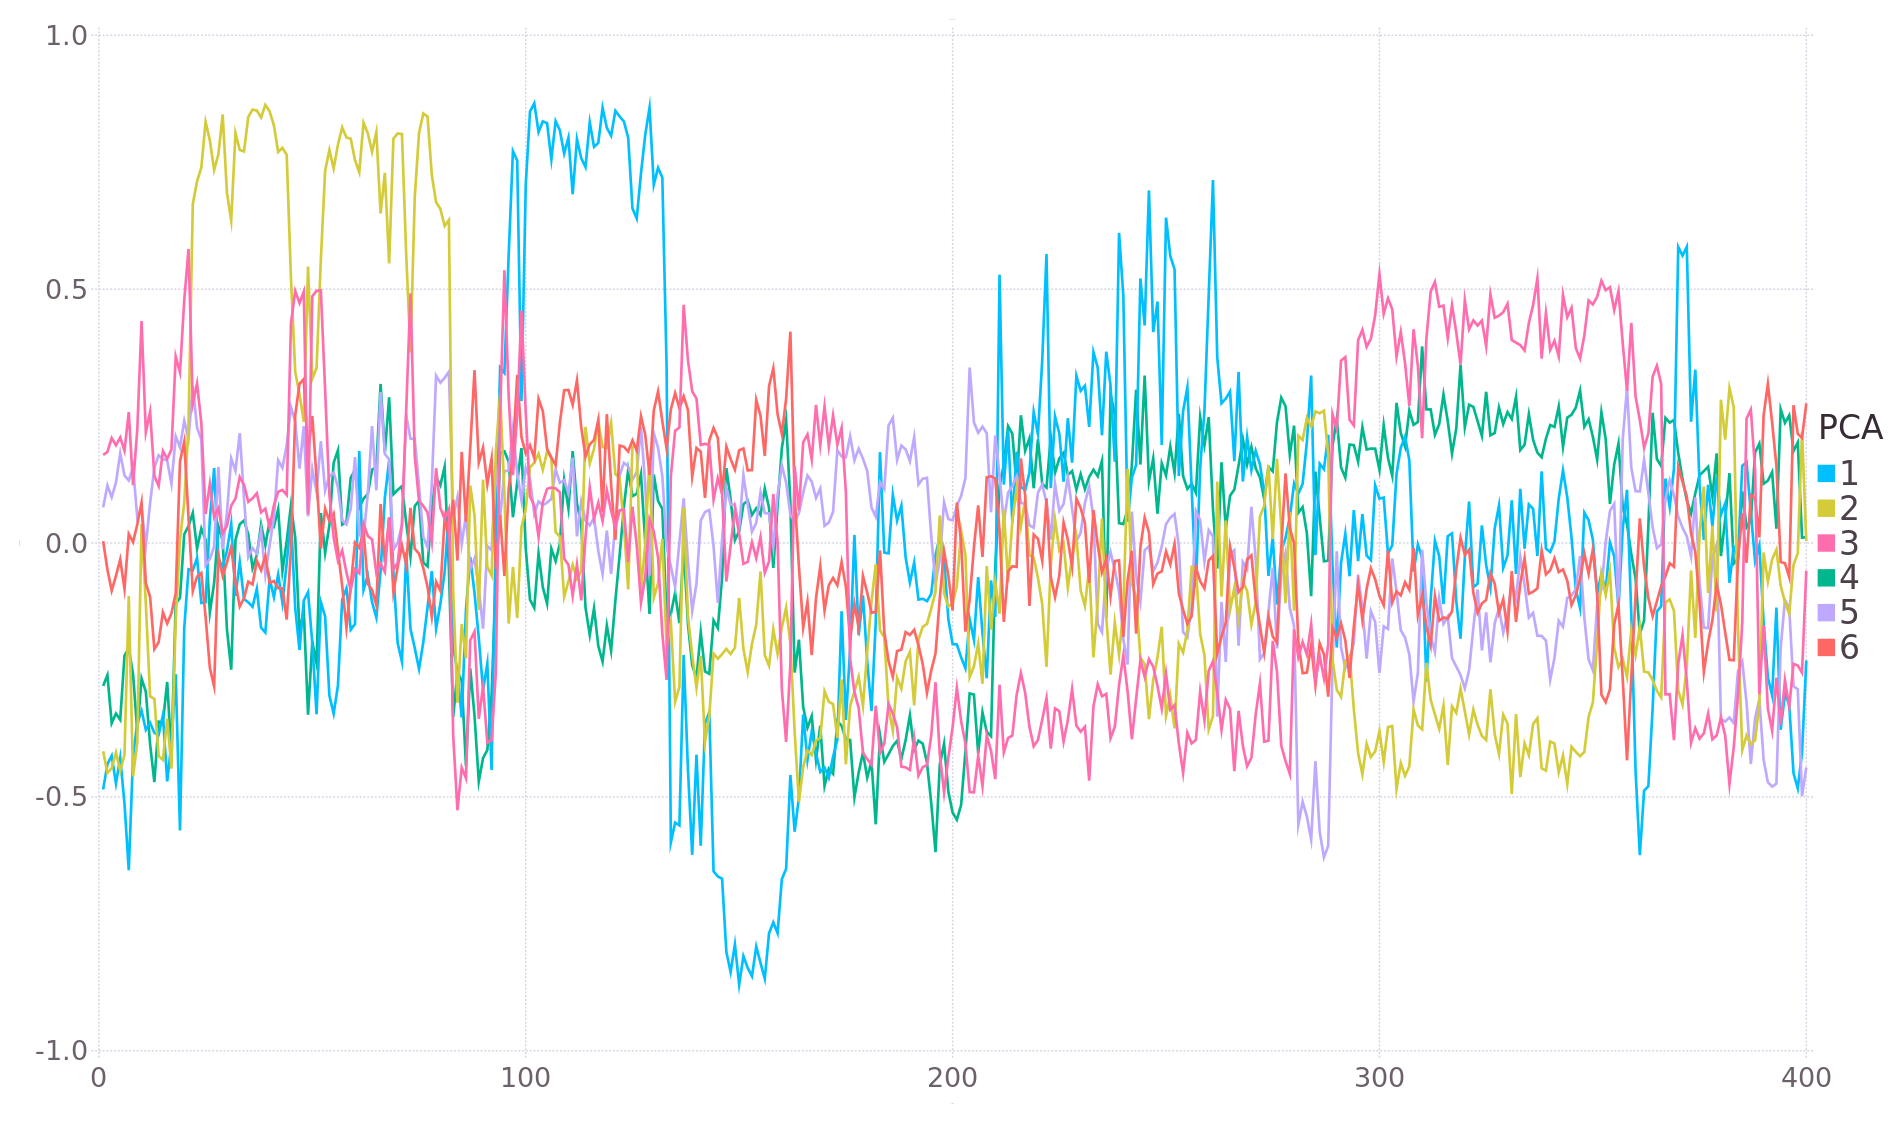

In [39]:
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+999]) for i = 1:1000:length(prj_1_4xcp)-999 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+999]) for i = 1:1000:length(prj_2_4xcp)-999 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+999]) for i = 1:1000:length(prj_3_4xcp)-999 ]
smooth_prj_4_4xcp = [ mean(prj_4_4xcp[i:i+999]) for i = 1:1000:length(prj_4_4xcp)-999 ]
smooth_prj_5_4xcp = [ mean(prj_5_4xcp[i:i+999]) for i = 1:1000:length(prj_5_4xcp)-999 ]
smooth_prj_6_4xcp = [ mean(prj_6_4xcp[i:i+999]) for i = 1:1000:length(prj_6_4xcp)-999 ];

df_prj_16_4xcp_smooth = DataFrame(Projection = [ smooth_prj_1_4xcp ; smooth_prj_2_4xcp ;
    smooth_prj_3_4xcp ; smooth_prj_4_4xcp ; smooth_prj_5_4xcp ; smooth_prj_6_4xcp ],
    PCA = repeat([ "1" ; "2" ; "3" ; "4" ; "5" ; "6" ], inner = length(smooth_prj_6_4xcp)),
    Time = repeat(collect(1:length(smooth_prj_6_4xcp)), outer = 6));

plot(df_prj_16_4xcp_smooth, x = "Time", y = "Projection", color = "PCA",
    #Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("0us - 4.0us"),
    #Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),

    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 2pt,
        key_title_font_size = 80pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

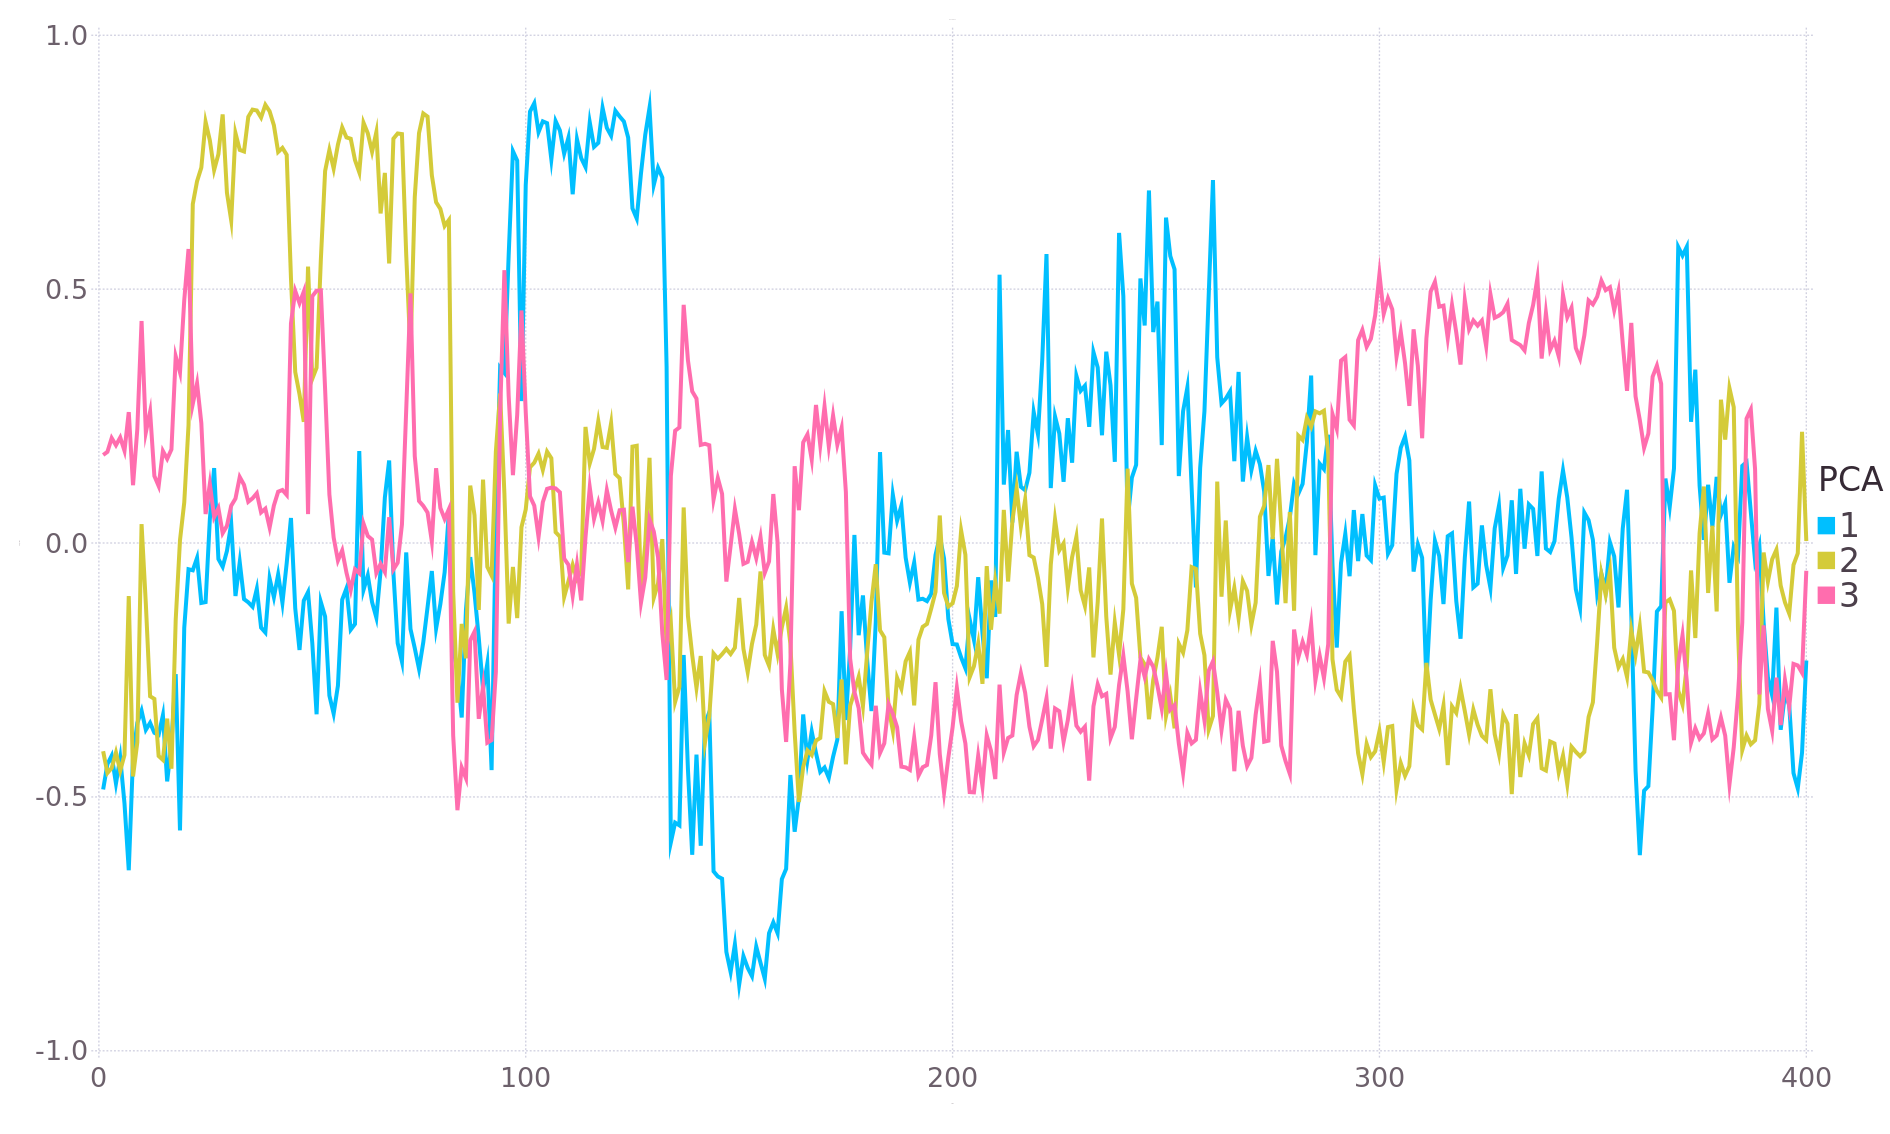

In [81]:
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+999]) for i = 1:1000:length(prj_1_4xcp)-999 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+999]) for i = 1:1000:length(prj_2_4xcp)-999 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+999]) for i = 1:1000:length(prj_3_4xcp)-999 ];

df_prj_16_4xcp_smooth = DataFrame(Projection = [ smooth_prj_1_4xcp ; smooth_prj_2_4xcp ;
    smooth_prj_3_4xcp ],
    PCA = repeat([ "1" ; "2" ; "3" ], inner = length(smooth_prj_6_4xcp)),
    Time = repeat(collect(1:length(smooth_prj_6_4xcp)), outer = 3));

plot(df_prj_16_4xcp_smooth, x = "Time", y = "Projection", color = "PCA",
    #Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("0us - 4.0us"),
    #Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),

    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 3pt,
        key_title_font_size = 80pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

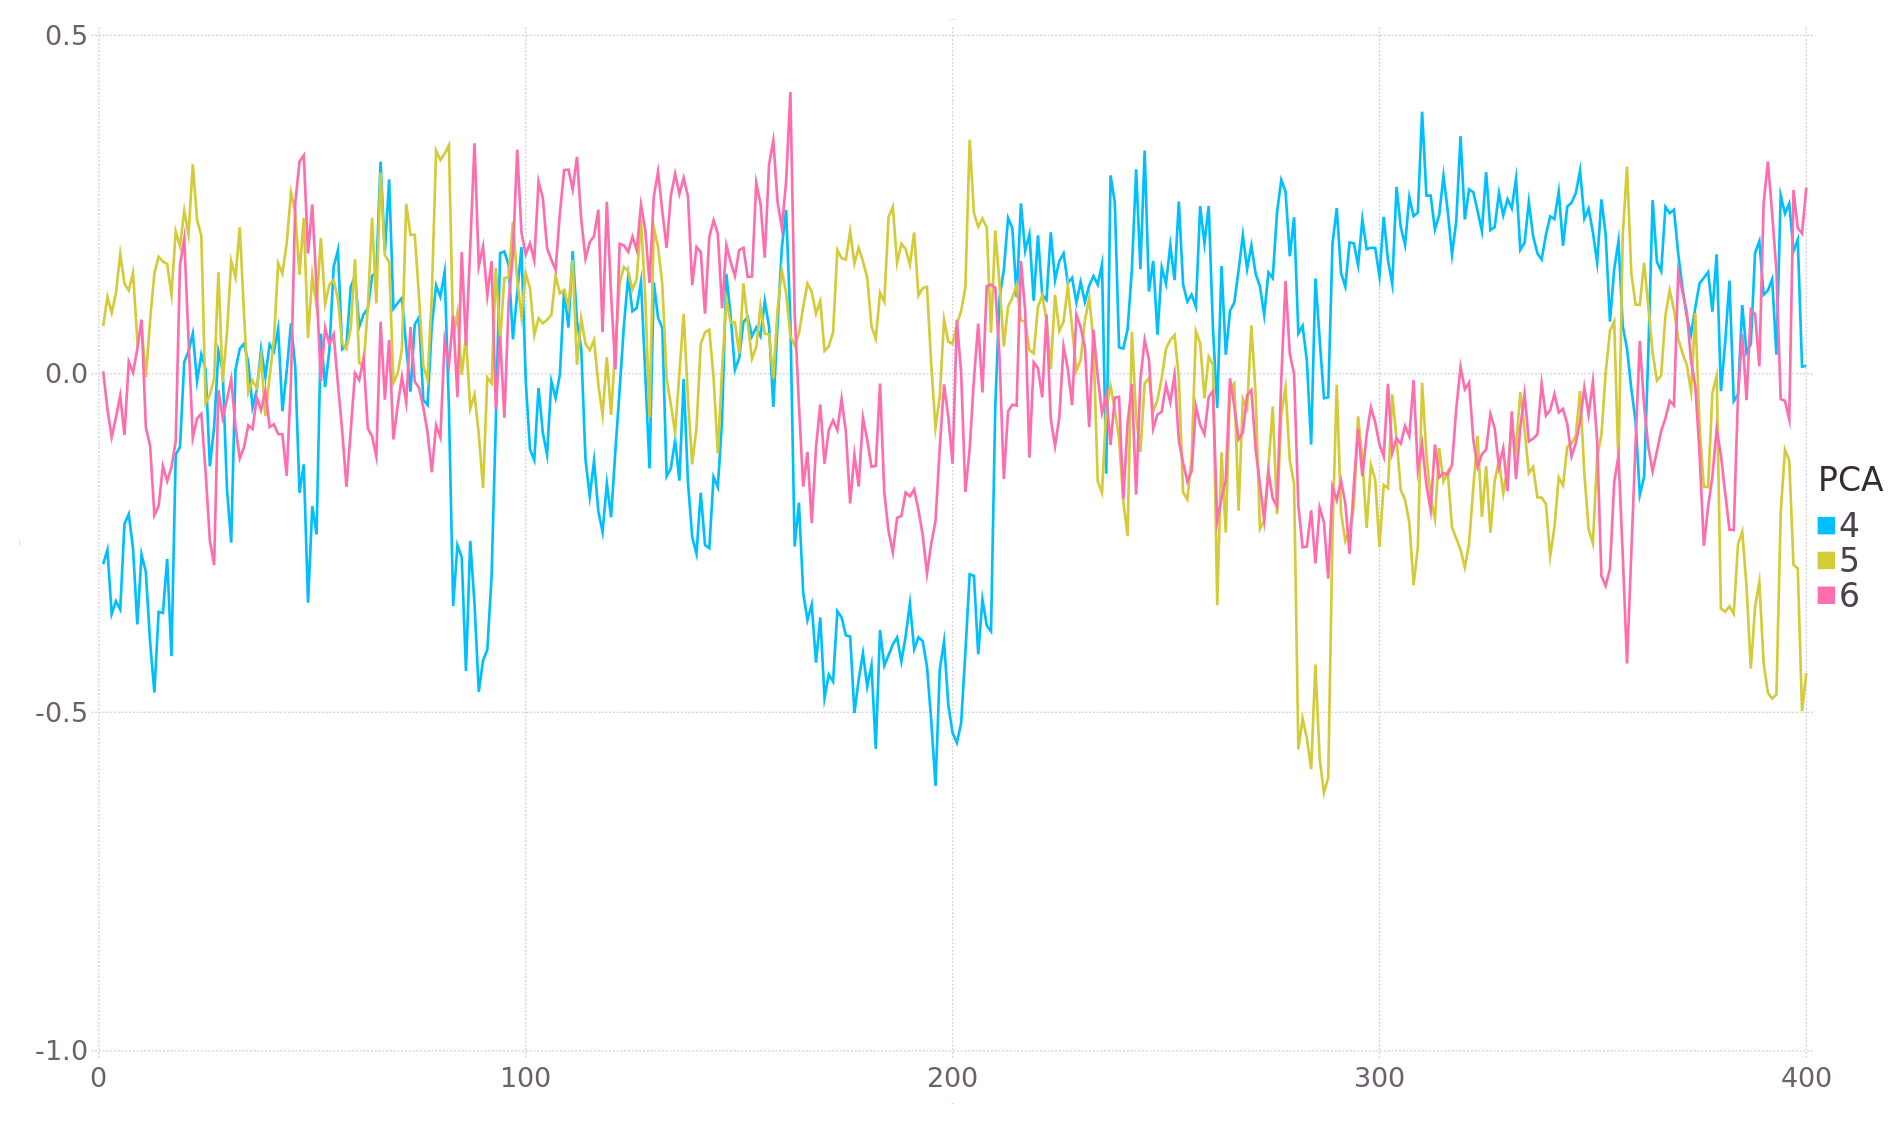

In [41]:
smooth_prj_4_4xcp = [ mean(prj_4_4xcp[i:i+999]) for i = 1:1000:length(prj_4_4xcp)-999 ]
smooth_prj_5_4xcp = [ mean(prj_5_4xcp[i:i+999]) for i = 1:1000:length(prj_5_4xcp)-999 ]
smooth_prj_6_4xcp = [ mean(prj_6_4xcp[i:i+999]) for i = 1:1000:length(prj_6_4xcp)-999 ];

df_prj_16_4xcp_smooth = DataFrame(Projection = [ smooth_prj_4_4xcp ; smooth_prj_5_4xcp ;
        smooth_prj_6_4xcp ],
    PCA = repeat([ "4" ; "5" ; "6" ], inner = length(smooth_prj_6_4xcp)),
    Time = repeat(collect(1:length(smooth_prj_6_4xcp)), outer = 3));

plot(df_prj_16_4xcp_smooth, x = "Time", y = "Projection", color = "PCA",
    #Coord.cartesian(xmin = 1, xmax = 6),
    Geom.path,
    Guide.title("0us - 4.0us"),
    #Scale.color_continuous(colormap = Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),

    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 2pt,
        key_title_font_size = 80pt,
        minor_label_font_size = 20pt, major_label_font_size = 1pt,
        key_title_font_size = 25pt, key_label_font_size = 25pt))

## Correlación entre PCA y vol

In [196]:
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);
df_trj_vol = DataFrame(Volume = trj_vol, Time = collect(1:length(trj_vol)));

smth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ];
smth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ];
smth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

smth_prj_4_4xcp = [ mean(prj_4_4xcp[i:i+9]) for i = 1:10:length(prj_4_4xcp)-9 ];
smth_prj_5_4xcp = [ mean(prj_5_4xcp[i:i+9]) for i = 1:10:length(prj_5_4xcp)-9 ];
smth_prj_6_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_6_4xcp)-9 ];

[ cor(trj_vol, smth_prj_1_4xcp) ; cor(trj_vol, smth_prj_2_4xcp) ; cor(trj_vol, smth_prj_3_4xcp) 
cor(trj_vol, smth_prj_4_4xcp) ; cor(trj_vol, smth_prj_5_4xcp) ; cor(trj_vol, smth_prj_6_4xcp) ]

6-element Array{Float64,1}:
 -0.503094 
 -0.501079 
  0.0745449
 -0.265582 
  0.240374 
  0.0745449

### PCAs de poblaciones

In [38]:
modes_0, evals_0 = read_ptraj_modes(joinpath(
        home, pdb, "poblaciones", "pca", string("full_modes_", pdb, "_0")))
modes_1, evals_1 = read_ptraj_modes(joinpath(
        home, pdb, "poblaciones", "pca", string("full_modes_", pdb, "_1")))
modes_2, evals_2 = read_ptraj_modes(joinpath(
        home, pdb, "poblaciones", "pca", string("full_modes_", pdb, "_2")));

diff_vol0 = readdlm(joinpath(rtdos, "diff_vol0"))
diff_vol1 = readdlm(joinpath(rtdos, "diff_vol1"))
diff_vol2 = readdlm(joinpath(rtdos, "diff_vol2"))

#0
nframes_0 = size(diff_vol0)[2]
norm_diff_0 = mapslices(x -> x ./ norm(x), diff_vol0, 1);

prj_1_0 = Array{Float64, 1}(nframes_0)
prj_2_0 = Array{Float64, 1}(nframes_0)
prj_3_0 = Array{Float64, 1}(nframes_0)
prj_4_0 = Array{Float64, 1}(nframes_0)
prj_5_0 = Array{Float64, 1}(nframes_0)
prj_6_0 = Array{Float64, 1}(nframes_0)

# 1
nframes_1 = size(diff_vol1)[2]
norm_diff_1 = mapslices(x -> x ./ norm(x), diff_vol1, 1);

prj_1_1 = Array{Float64, 1}(nframes_1)
prj_2_1 = Array{Float64, 1}(nframes_1)
prj_3_1 = Array{Float64, 1}(nframes_1)
prj_4_1 = Array{Float64, 1}(nframes_1)
prj_5_1 = Array{Float64, 1}(nframes_1)
prj_6_1 = Array{Float64, 1}(nframes_1)

# 2
nframes_2 = size(diff_vol2)[2]
norm_diff_2 = mapslices(x -> x ./ norm(x), diff_vol2, 1);

prj_1_2 = Array{Float64, 1}(nframes_2)
prj_2_2 = Array{Float64, 1}(nframes_2)
prj_3_2 = Array{Float64, 1}(nframes_2)
prj_4_2 = Array{Float64, 1}(nframes_2)
prj_5_2 = Array{Float64, 1}(nframes_2)
prj_6_2 = Array{Float64, 1}(nframes_2);

In [ ]:
df_prj_4xcp = DataFrame(PCA1 = prj_1_4xcp, PCA2 = prj_2_4xcp,
    Time = collect(1:length(prj_1_4xcp)));

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+10]) for i = 1:10:length(prj_1_4xcp)-10 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+10]) for i = 1:10:length(prj_2_4xcp)-10 ];

df_smooth_prj_4xcp = DataFrame(PCA1 = smooth_prj_1_4xcp, PCA2 = smooth_prj_2_4xcp,
    Time = collect(1:length(smooth_prj_1_4xcp)));

In [39]:
# 0
for i = 1:nframes_0
    prj_1_0[i] = dot(norm_diff_0[:, i], modes_0[:, 1])
    prj_2_0[i] = dot(norm_diff_0[:, i], modes_0[:, 2])
    prj_3_0[i] = dot(norm_diff_0[:, i], modes_0[:, 3])
    prj_4_0[i] = dot(norm_diff_0[:, i], modes_0[:, 4])
    prj_5_0[i] = dot(norm_diff_0[:, i], modes_0[:, 5])
    prj_6_0[i] = dot(norm_diff_0[:, i], modes_0[:, 6])
end

# 1
for i = 1:nframes_1
    prj_1_1[i] = dot(norm_diff_1[:, i], modes_1[:, 1])
    prj_2_1[i] = dot(norm_diff_1[:, i], modes_1[:, 2])
    prj_3_1[i] = dot(norm_diff_1[:, i], modes_1[:, 3])
    prj_4_1[i] = dot(norm_diff_1[:, i], modes_1[:, 4])
    prj_5_1[i] = dot(norm_diff_1[:, i], modes_1[:, 5])
    prj_6_1[i] = dot(norm_diff_1[:, i], modes_1[:, 6])
end

# 2
for i = 1:nframes_2
    prj_1_2[i] = dot(norm_diff_2[:, i], modes_2[:, 1])
    prj_2_2[i] = dot(norm_diff_2[:, i], modes_2[:, 2])
    prj_3_2[i] = dot(norm_diff_2[:, i], modes_2[:, 3])
    prj_4_2[i] = dot(norm_diff_2[:, i], modes_2[:, 4])
    prj_5_2[i] = dot(norm_diff_2[:, i], modes_2[:, 5])
    prj_6_2[i] = dot(norm_diff_2[:, i], modes_2[:, 6])
end

In [206]:
# Vol
trj_vol0 = [ mean(full_trj_vol_0[i:i+9]) for i = 1:10:length(full_trj_vol_0)-9 ];
trj_vol1 = [ mean(full_trj_vol_1[i:i+9]) for i = 1:10:length(full_trj_vol_1)-9 ];
trj_vol2 = [ mean(full_trj_vol_2[i:i+9]) for i = 1:10:length(full_trj_vol_2)-9 ];

# 0
smth_prj_1_0 = [ mean(prj_1_0[i:i+9]) for i = 1:10:length(prj_1_0)-9 ];
smth_prj_2_0 = [ mean(prj_2_0[i:i+9]) for i = 1:10:length(prj_2_0)-9 ];
smth_prj_3_0 = [ mean(prj_3_0[i:i+9]) for i = 1:10:length(prj_3_0)-9 ];

smth_prj_4_0 = [ mean(prj_4_0[i:i+9]) for i = 1:10:length(prj_4_0)-9 ];
smth_prj_5_0 = [ mean(prj_5_0[i:i+9]) for i = 1:10:length(prj_5_0)-9 ];
smth_prj_6_0 = [ mean(prj_3_0[i:i+9]) for i = 1:10:length(prj_6_0)-9 ];

[ cor(trj_vol0, smth_prj_1_0) ; cor(trj_vol0, smth_prj_2_0) ; cor(trj_vol0, smth_prj_3_0)
cor(trj_vol0, smth_prj_4_0) ; cor(trj_vol0, smth_prj_5_0) ; cor(trj_vol0, smth_prj_6_0) ]

6-element Array{Float64,1}:
 -0.567619 
 -0.0296112
 -0.581775 
 -0.337113 
 -0.216361 
 -0.581775 

In [207]:
# 1
smth_prj_1_1 = [ mean(prj_1_1[i:i+9]) for i = 1:10:length(prj_1_1)-9 ];
smth_prj_2_1 = [ mean(prj_2_1[i:i+9]) for i = 1:10:length(prj_2_1)-9 ];
smth_prj_3_1 = [ mean(prj_3_1[i:i+9]) for i = 1:10:length(prj_3_1)-9 ];

smth_prj_4_1 = [ mean(prj_4_1[i:i+9]) for i = 1:10:length(prj_4_1)-9 ];
smth_prj_5_1 = [ mean(prj_5_1[i:i+9]) for i = 1:10:length(prj_5_1)-9 ];
smth_prj_6_1 = [ mean(prj_3_1[i:i+9]) for i = 1:10:length(prj_6_1)-9 ];

[ cor(trj_vol1, smth_prj_1_1) ; cor(trj_vol1, smth_prj_2_1) ; cor(trj_vol1, smth_prj_3_1)
cor(trj_vol1, smth_prj_4_1) ; cor(trj_vol1, smth_prj_5_1) ; cor(trj_vol1, smth_prj_6_1) ]

6-element Array{Float64,1}:
 -0.30859  
 -0.179306 
 -0.0319875
 -0.455252 
  0.0744239
 -0.0319875

In [208]:
# 2
smth_prj_1_2 = [ mean(prj_1_2[i:i+9]) for i = 1:10:length(prj_1_2)-9 ];
smth_prj_2_2 = [ mean(prj_2_2[i:i+9]) for i = 1:10:length(prj_2_2)-9 ];
smth_prj_3_2 = [ mean(prj_3_2[i:i+9]) for i = 1:10:length(prj_3_2)-9 ];

smth_prj_4_2 = [ mean(prj_4_2[i:i+9]) for i = 1:10:length(prj_4_2)-9 ];
smth_prj_5_2 = [ mean(prj_5_2[i:i+9]) for i = 1:10:length(prj_5_2)-9 ];
smth_prj_6_2 = [ mean(prj_3_2[i:i+9]) for i = 1:10:length(prj_6_2)-9 ];

[ cor(trj_vol2, smth_prj_1_2) ; cor(trj_vol2, smth_prj_2_2) ; cor(trj_vol2, smth_prj_3_2)
cor(trj_vol2, smth_prj_4_2) ; cor(trj_vol2, smth_prj_5_2) ; cor(trj_vol2, smth_prj_6_2) ]

6-element Array{Float64,1}:
 -0.567775  
 -0.00393083
  0.0774329 
  0.29583   
 -0.179069  
  0.0774329 

## Pocket

In [182]:
cas_poc = [ 1 ; 4 ; 5 ; 6 ; 9 ; 12 ; 13 ; 16 ; 21 ; 24 ; 54 ;
    57 ; 58 ; 61 ; 65 ; 75 ; 76 ; 79 ; 80 ; 83 ; 84 ; 86 ; 87 ;
    90 ; 91 ; 96 ; 101 ; 104 ; 105 ; 108 ; 112 ; 123 ; 127 ; 130 ; 131 ; 133 ; 134 ];

aa_poc = length(cas_poc)
cas_poc_idx = Array{Int64}(aa_poc * 3)
for i = 1:aa_poc
    cas_poc_idx[i*3-2] = cas_poc[i] * 3 - 2
    cas_poc_idx[i*3-1] = cas_poc[i] * 3 - 1
    cas_poc_idx[i*3] = cas_poc[i] * 3
end

norm_diff_poc = norm_diff_4xcp[cas_poc_idx, :]

prj_1_poc = Array{Float64, 1}(nframes)
prj_2_poc = Array{Float64, 1}(nframes)
prj_3_poc = Array{Float64, 1}(nframes)
prj_4_poc = Array{Float64, 1}(nframes)
prj_5_poc = Array{Float64, 1}(nframes)
prj_6_poc = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_poc[i] = dot(norm_diff_poc[:, i], modes_4xcp[cas_poc_idx, 1])
    prj_2_poc[i] = dot(norm_diff_poc[:, i], modes_4xcp[cas_poc_idx, 2])
    prj_3_poc[i] = dot(norm_diff_poc[:, i], modes_4xcp[cas_poc_idx, 3])
    prj_4_poc[i] = dot(norm_diff_poc[:, i], modes_4xcp[cas_poc_idx, 4])
    prj_5_poc[i] = dot(norm_diff_poc[:, i], modes_4xcp[cas_poc_idx, 5])
    prj_6_poc[i] = dot(norm_diff_poc[:, i], modes_4xcp[cas_poc_idx, 6])
end

In [185]:
smth_prj_1_poc = [ mean(prj_1_poc[i:i+9]) for i = 1:10:length(prj_1_poc)-9 ]; 
smth_prj_2_poc = [ mean(prj_2_poc[i:i+9]) for i = 1:10:length(prj_2_poc)-9 ]; 
smth_prj_3_poc = [ mean(prj_3_poc[i:i+9]) for i = 1:10:length(prj_3_poc)-9 ]; 

smth_prj_4_poc = [ mean(prj_4_poc[i:i+9]) for i = 1:10:length(prj_4_poc)-9 ]; 
smth_prj_5_poc = [ mean(prj_5_poc[i:i+9]) for i = 1:10:length(prj_5_poc)-9 ]; 
smth_prj_6_poc = [ mean(prj_3_poc[i:i+9]) for i = 1:10:length(prj_6_poc)-9 ]; 

In [187]:
[ cor(trj_vol, smth_prj_1_poc) ; cor(trj_vol, smth_prj_2_poc) ; cor(trj_vol, smth_prj_3_poc) 
cor(trj_vol, smth_prj_4_poc) ; cor(trj_vol, smth_prj_5_poc) ; cor(trj_vol, smth_prj_6_poc) ]

6-element Array{Float64,1}:
 -0.642499
 -0.585282
  0.177614
 -0.308826
  0.257125
  0.177614

### Pocket y poblaciones

In [193]:
#0
nframes_0_poc = size(diff_vol0)[2]
norm_diff_0_poc = norm_diff_0[cas_poc_idx, :]

prj_1_0_poc = Array{Float64, 1}(nframes_0_poc)
prj_2_0_poc = Array{Float64, 1}(nframes_0_poc)
prj_3_0_poc = Array{Float64, 1}(nframes_0_poc)
prj_4_0_poc = Array{Float64, 1}(nframes_0_poc)
prj_5_0_poc = Array{Float64, 1}(nframes_0_poc)
prj_6_0_poc = Array{Float64, 1}(nframes_0_poc)

# 1
nframes_1_poc = size(diff_vol1)[2]
norm_diff_1_poc = norm_diff_1[cas_poc_idx, :]

prj_1_1_poc = Array{Float64, 1}(nframes_1_poc)
prj_2_1_poc = Array{Float64, 1}(nframes_1_poc)
prj_3_1_poc = Array{Float64, 1}(nframes_1_poc)
prj_4_1_poc = Array{Float64, 1}(nframes_1_poc)
prj_5_1_poc = Array{Float64, 1}(nframes_1_poc)
prj_6_1_poc = Array{Float64, 1}(nframes_1_poc)

# 2
nframes_2_poc = size(diff_vol2)[2]
norm_diff_2_poc = norm_diff_2[cas_poc_idx, :]

prj_1_2_poc = Array{Float64, 1}(nframes_2_poc)
prj_2_2_poc = Array{Float64, 1}(nframes_2_poc)
prj_3_2_poc = Array{Float64, 1}(nframes_2_poc)
prj_4_2_poc = Array{Float64, 1}(nframes_2_poc)
prj_5_2_poc = Array{Float64, 1}(nframes_2_poc)
prj_6_2_poc = Array{Float64, 1}(nframes_2_poc);

In [194]:
# 0
for i = 1:nframes_0_poc
    prj_1_0_poc[i] = dot(norm_diff_0_poc[:, i], modes_0[cas_poc_idx, 1]) 
    prj_2_0_poc[i] = dot(norm_diff_0_poc[:, i], modes_0[cas_poc_idx, 2]) 
    prj_3_0_poc[i] = dot(norm_diff_0_poc[:, i], modes_0[cas_poc_idx, 3]) 
    prj_4_0_poc[i] = dot(norm_diff_0_poc[:, i], modes_0[cas_poc_idx, 4]) 
    prj_5_0_poc[i] = dot(norm_diff_0_poc[:, i], modes_0[cas_poc_idx, 5]) 
    prj_6_0_poc[i] = dot(norm_diff_0_poc[:, i], modes_0[cas_poc_idx, 6]) 
end

# 1
for i = 1:nframes_1
    prj_1_1_poc[i] = dot(norm_diff_1_poc[:, i], modes_1[cas_poc_idx, 1]) 
    prj_2_1_poc[i] = dot(norm_diff_1_poc[:, i], modes_1[cas_poc_idx, 2]) 
    prj_3_1_poc[i] = dot(norm_diff_1_poc[:, i], modes_1[cas_poc_idx, 3]) 
    prj_4_1_poc[i] = dot(norm_diff_1_poc[:, i], modes_1[cas_poc_idx, 4]) 
    prj_5_1_poc[i] = dot(norm_diff_1_poc[:, i], modes_1[cas_poc_idx, 5]) 
    prj_6_1_poc[i] = dot(norm_diff_1_poc[:, i], modes_1[cas_poc_idx, 6]) 
end

# 2
for i = 1:nframes_2
    prj_1_2_poc[i] = dot(norm_diff_2_poc[:, i], modes_2[cas_poc_idx, 1]) 
    prj_2_2_poc[i] = dot(norm_diff_2_poc[:, i], modes_2[cas_poc_idx, 2]) 
    prj_3_2_poc[i] = dot(norm_diff_2_poc[:, i], modes_2[cas_poc_idx, 3]) 
    prj_4_2_poc[i] = dot(norm_diff_2_poc[:, i], modes_2[cas_poc_idx, 4]) 
    prj_5_2_poc[i] = dot(norm_diff_2_poc[:, i], modes_2[cas_poc_idx, 5]) 
    prj_6_2_poc[i] = dot(norm_diff_2_poc[:, i], modes_2[cas_poc_idx, 6]) 
end

In [191]:
norm_diff_0_poc

405×171831 Array{Float64,2}:
  0.038739     0.0288286   0.0451257    …  -0.0237785   -0.00967828 
 -0.0479718   -0.0409153  -0.0482432        0.0674748    0.0695432  
 -0.0993679   -0.0812962  -0.110288         0.0233222    0.0663932  
  0.0296961    0.022452    0.0377418       -0.0176733    0.00512294 
  7.44652e-5  -0.0418596  -0.0187697        0.0451496    0.0504648  
 -0.0922096   -0.067421   -0.118588     …   0.00848615   0.0325739  
  0.0320524    0.0744446   0.0509125       -0.0338842   -0.035919   
 -0.0459408   -0.0947658  -0.0738399        0.0541606    0.0852524  
 -0.129773    -0.106362   -0.154993         0.016252     0.04883    
  0.036842     0.0631542   0.012505        -0.0208128   -0.0172489  
 -0.0724177   -0.103015   -0.0970098    …   0.0577473    0.0850174  
 -0.0921538   -0.0705032  -0.108245         0.00709216   0.0409734  
  0.00334467   0.0445872  -0.000471588     -0.0300959   -0.0281953  
  ⋮                                     ⋱                ⋮          
 -0.0

In [49]:
# 0
smth_prj_1_0 = [ mean(prj_1_0[i:i+9]) for i = 1:10:length(prj_1_0)-9 ];
smth_prj_2_0 = [ mean(prj_2_0[i:i+9]) for i = 1:10:length(prj_2_0)-9 ];
smth_prj_3_0 = [ mean(prj_3_0[i:i+9]) for i = 1:10:length(prj_3_0)-9 ];

smth_prj_4_0 = [ mean(prj_4_0[i:i+9]) for i = 1:10:length(prj_4_0)-9 ];
smth_prj_5_0 = [ mean(prj_5_0[i:i+9]) for i = 1:10:length(prj_5_0)-9 ];
smth_prj_6_0 = [ mean(prj_3_0[i:i+9]) for i = 1:10:length(prj_6_0)-9 ];

# 1
smth_prj_1_1 = [ mean(prj_1_1[i:i+9]) for i = 1:10:length(prj_1_1)-9 ];
smth_prj_2_1 = [ mean(prj_2_1[i:i+9]) for i = 1:10:length(prj_2_1)-9 ];
smth_prj_3_1 = [ mean(prj_3_1[i:i+9]) for i = 1:10:length(prj_3_1)-9 ];

smth_prj_4_1 = [ mean(prj_4_1[i:i+9]) for i = 1:10:length(prj_4_1)-9 ];
smth_prj_5_1 = [ mean(prj_5_1[i:i+9]) for i = 1:10:length(prj_5_1)-9 ];
smth_prj_6_1 = [ mean(prj_3_1[i:i+9]) for i = 1:10:length(prj_6_1)-9 ];

# 2
smth_prj_1_2 = [ mean(prj_1_2[i:i+9]) for i = 1:10:length(prj_1_2)-9 ];
smth_prj_2_2 = [ mean(prj_2_2[i:i+9]) for i = 1:10:length(prj_2_2)-9 ];
smth_prj_3_2 = [ mean(prj_3_2[i:i+9]) for i = 1:10:length(prj_3_2)-9 ];

smth_prj_4_2 = [ mean(prj_4_2[i:i+9]) for i = 1:10:length(prj_4_2)-9 ];
smth_prj_5_2 = [ mean(prj_5_2[i:i+9]) for i = 1:10:length(prj_5_2)-9 ];
smth_prj_6_2 = [ mean(prj_3_2[i:i+9]) for i = 1:10:length(prj_6_2)-9 ];

In [54]:
# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

full_trj_vol_0 = full_trj_vol[idx_vol0]
full_trj_vol_1 = full_trj_vol[idx_vol1]
full_trj_vol_2 = full_trj_vol[idx_vol2]

smt_trj_vol_0 = [ full_trj_vol_0[i] for i = 1:10:length(full_trj_vol_0)-9 ];
smt_trj_vol_1 = [ full_trj_vol_1[i] for i = 1:10:length(full_trj_vol_1)-9 ];
smt_trj_vol_2 = [ full_trj_vol_2[i] for i = 1:10:length(full_trj_vol_2)-9 ];

In [58]:
[ cor(smt_trj_vol_0, smth_prj_1_0) ; cor(smt_trj_vol_0, smth_prj_2_0) ; cor(smt_trj_vol_0, smth_prj_3_0)
cor(smt_trj_vol_0, smth_prj_4_0) ; cor(smt_trj_vol_0, smth_prj_5_0) ; cor(smt_trj_vol_0, smth_prj_6_0) ]

6-element Array{Float64,1}:
 -0.45718   
  0.00923827
 -0.411728  
 -0.282287  
 -0.16155   
 -0.411728  

In [59]:
[ cor(smt_trj_vol_1, smth_prj_1_1) ; cor(smt_trj_vol_1, smth_prj_2_1) ; cor(smt_trj_vol_1, smth_prj_3_1)
cor(smt_trj_vol_1, smth_prj_4_1) ; cor(smt_trj_vol_1, smth_prj_5_1) ; cor(smt_trj_vol_1, smth_prj_6_1) ]

6-element Array{Float64,1}:
 -0.167063 
 -0.104112 
 -0.044151 
 -0.269803 
  0.0157753
 -0.044151 

In [60]:
[ cor(smt_trj_vol_2, smth_prj_1_2) ; cor(smt_trj_vol_2, smth_prj_2_2) ; cor(smt_trj_vol_2, smth_prj_3_2)
cor(smt_trj_vol_2, smth_prj_4_2) ; cor(smt_trj_vol_2, smth_prj_5_2) ; cor(smt_trj_vol_2, smth_prj_6_2) ]

6-element Array{Float64,1}:
 -0.36025  
 -0.0273398
  0.0249527
  0.159379 
 -0.0991665
  0.0249527

### Correlación PCA pro PCA lig

In [68]:
modes_lig, evals_lig = read_ptraj_modes(joinpath(
        home, pdb, "lig", "pca", string("full_modes_lig_", pdb)))

diff_lig = readdlm(joinpath(rtdos, "diff_lig"))
nframes = size(diff_lig)[2]
norm_diff_lig = mapslices(x -> x ./ norm(x), diff_lig, 1);

In [74]:
prj_1_lig = Array{Float64, 1}(nframes)
prj_2_lig = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_lig[i] = dot(norm_diff_lig[:, i], modes_lig[:, 1])
    prj_2_lig[i] = dot(norm_diff_lig[:, i], modes_lig[:, 2])
end

df_prj_lig = DataFrame(PCA1 = prj_1_lig, PCA2 = prj_2_lig,
    Time = collect(1:length(prj_1_lig)));

# Smooth
smooth_prj_1_lig = [ mean(prj_1_lig[i:i+10]) for i = 1:10:length(prj_1_lig)-10 ]
smooth_prj_2_lig = [ mean(prj_2_lig[i:i+10]) for i = 1:10:length(prj_2_lig)-10 ]; 

In [75]:
[ cor(prj_1_4xcp, prj_1_lig)  cor(prj_1_4xcp, prj_2_lig) ;
    cor(prj_2_4xcp, prj_1_lig) cor(prj_2_4xcp, prj_2_lig) ]

2×2 Array{Float64,2}:
 0.241414  0.107655
 0.235599  0.363823

### Correlación PCA lig y vol

In [135]:
[ cor(prj_1_lig[idx_vol0], full_trj_vol_0) cor(prj_2_lig[idx_vol0], full_trj_vol_0) ;
 cor(prj_1_lig[idx_vol1], full_trj_vol_1) cor(prj_2_lig[idx_vol1], full_trj_vol_1) ; 
cor(prj_1_lig[idx_vol2], full_trj_vol_2) cor(prj_2_lig[idx_vol2], full_trj_vol_2) ]

3×2 Array{Float64,2}:
 -0.119145     0.011448
 -0.062443    -0.227081
 -0.00641247  -0.343851

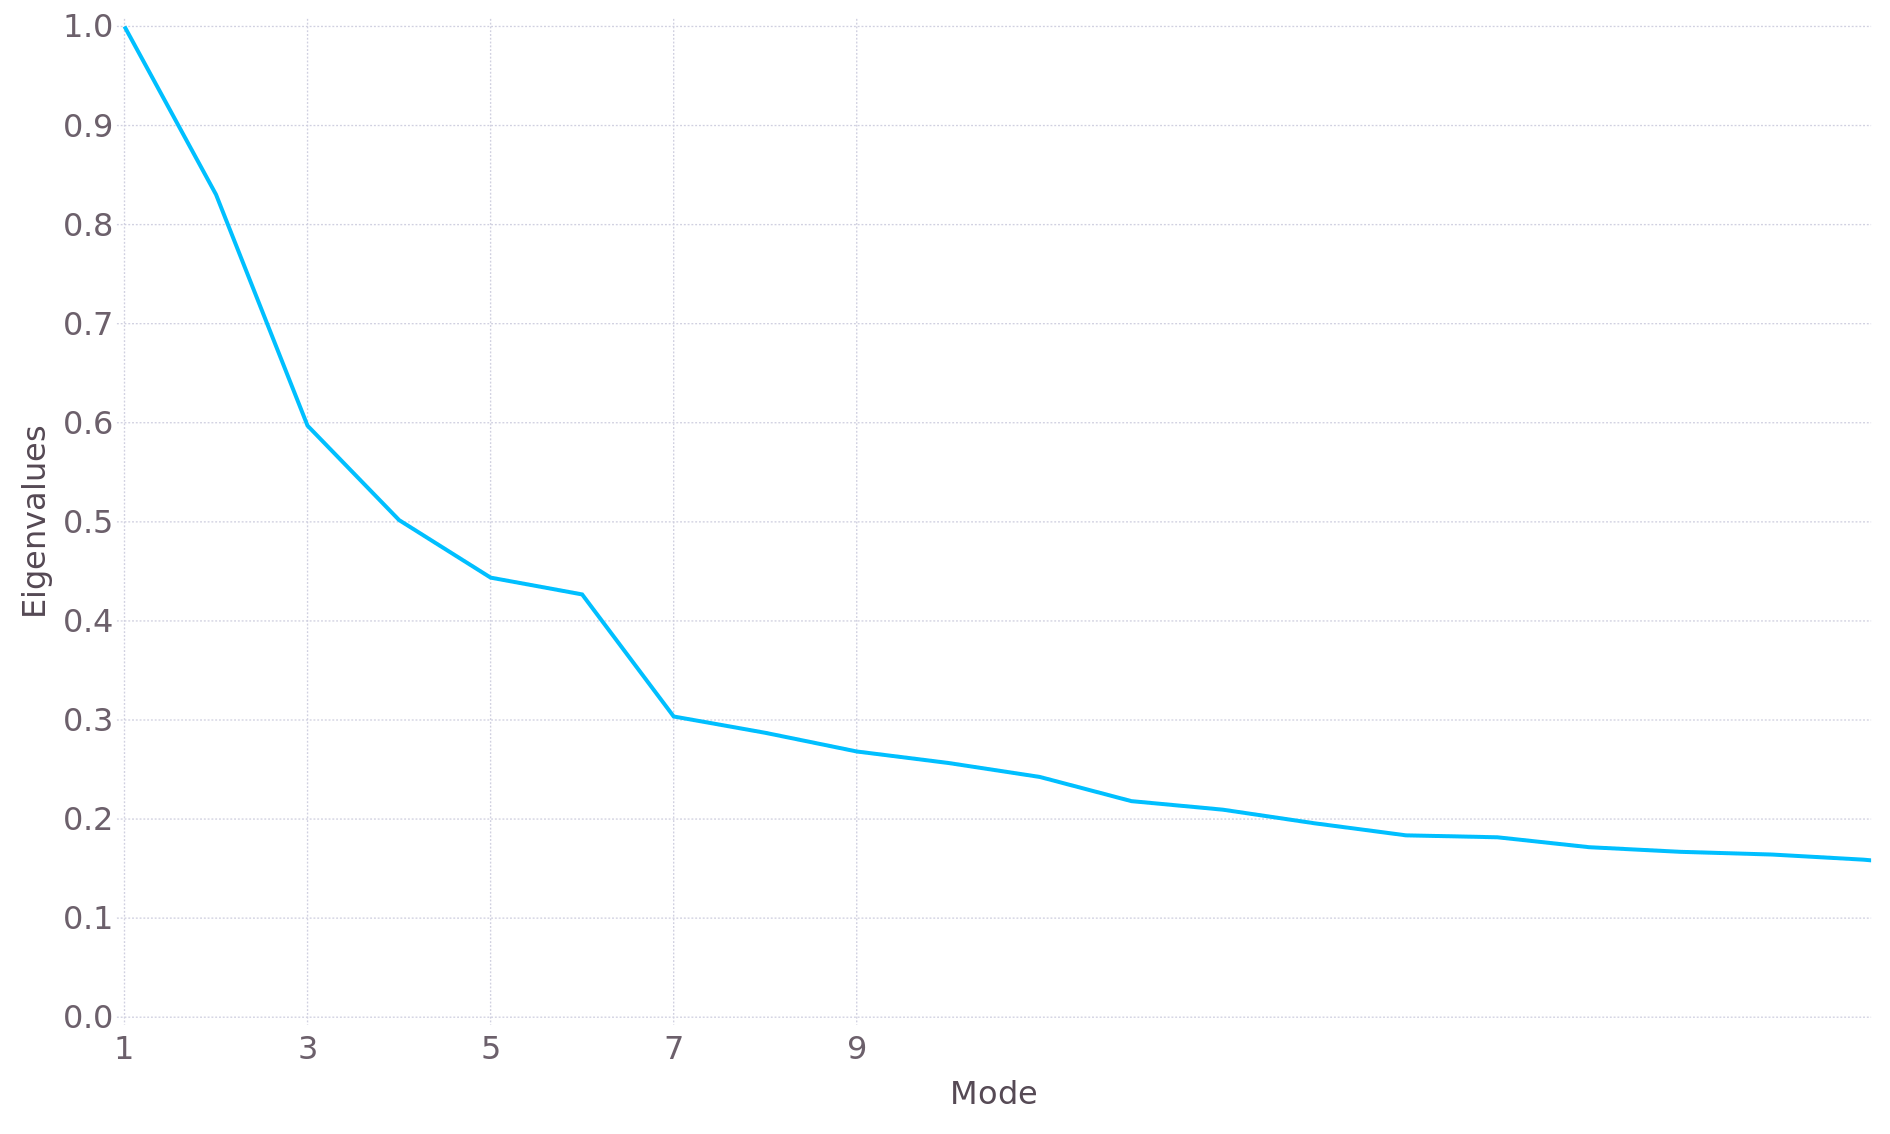

In [80]:
tmp = 1 ./ evals_4xcp
evals = tmp ./ tmp[1]
df_evals = DataFrame(Eigenvalues = evals, Mode = collect(1:length(evals_4xcp)))

plot(df_evals, x = "Mode", y = "Eigenvalues",  
    Geom.line,
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 1, xmax = 20),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:5y:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.yticks(ticks = collect(.0:.1:1)),
    Guide.xticks(ticks = collect(1:2:10)),
    #Guide.xticks(ticks = [ collect(1:2:10) ; 20 ; 50 ; 100 ; 200 ]),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, line_width = 3pt,
        minor_label_font_size = 24pt, major_label_font_size = 24pt, key_title_font_size = 20pt))

## PCA combinado

405-element Array{Float64,1}:
 -0.0645278 
 -0.00481706
  0.0405464 
 -0.0679586 
  0.0114708 
  0.0402345 
 -0.0840039 
  0.0329916 
  0.0536807 
 -0.0512895 
  0.0314322 
  0.0395414 
 -0.0301499 
  ⋮         
 -0.0343778 
 -0.0198574 
  0.013966  
 -0.0371156 
 -0.0333728 
  0.00752015
 -0.0260606 
 -0.0396454 
  0.00107431
 -0.0316401 
 -0.0367344 
  0.00315361

In [ ]:
modes_4xcp_12 = modes_4xcp[:, 1] * 1 / evals_4xcp[1] + modes_4xcp[:, 2] * 1 / evals_4xcp[2]
modes_4xcp_16 = modes_4xcp[:, 1] * 1 / evals_4xcp[1] + modes_4xcp[:, 2] * 1 / evals_4xcp[2] +
modes_4xcp[:, 3] * 1 / evals_4xcp[3] + modes_4xcp[:, 4] * 1 / evals_4xcp[4]
+ modes_4xcp[:, 5] * 1 / evals_4xcp[5] + modes_4xcp[:, 6] * 1 / evals_4xcp[6];

prj_12_4xcp = Array{Float64, 1}(nframes)
prj_16_4xcp = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_12_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp_12)
    prj_16_4xcp[i] = dot(norm_diff_4xcp[:, i], modes_4xcp_16)
end

smooth_prj_12_4xcp = [ mean(prj_12_4xcp[i:i+10]) for i = 1:10:length(prj_12_4xcp)-10 ]
smooth_prj_16_4xcp = [ mean(prj_16_4xcp[i:i+10]) for i = 1:10:length(prj_16_4xcp)-10 ];

In [222]:
smooth_prj_12_4xcp = [ mean(prj_12_4xcp[i:i+10]) for i = 1:10:length(prj_12_4xcp)-10 ]
smooth_prj_16_4xcp = [ mean(prj_16_4xcp[i:i+10]) for i = 1:10:length(prj_16_4xcp)-10 ];

In [224]:
cortrj_vol

40000-element Array{Float64,1}:
 1196.07 
 1177.02 
 1148.0  
 1186.67 
 1196.2  
 1072.55 
 1217.11 
 1102.37 
 1273.87 
 1303.47 
 1362.44 
 1304.86 
 1248.95 
    ⋮    
  585.797
  509.781
  558.44 
  540.793
  570.277
  699.706
  582.57 
  606.322
  645.535
  728.997
  603.807
  542.797